<a href="https://colab.research.google.com/github/rithuzwar/Customer-Segmentation-Using-rfm-analysis/blob/main/project_2_clustering_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np

df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
#MISSING VALUES
df.isnull().sum()
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [29]:
# REMOVING MISSING VALUE ROWS
df.dropna(subset=['CustomerID'], inplace=True)

df = df[df['Quantity'] > 0]
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

<ipython-input-29-39f0cf141770>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)
<ipython-input-29-39f0cf141770>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [30]:
# GOURPING
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'Quantity': 'sum'      # Monetary (Total quantity purchased, or you can substitute with another metric if needed)
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,74215
1,12347,1,182,2458
2,12348,74,31,2341
3,12349,18,73,631
4,12350,309,17,197


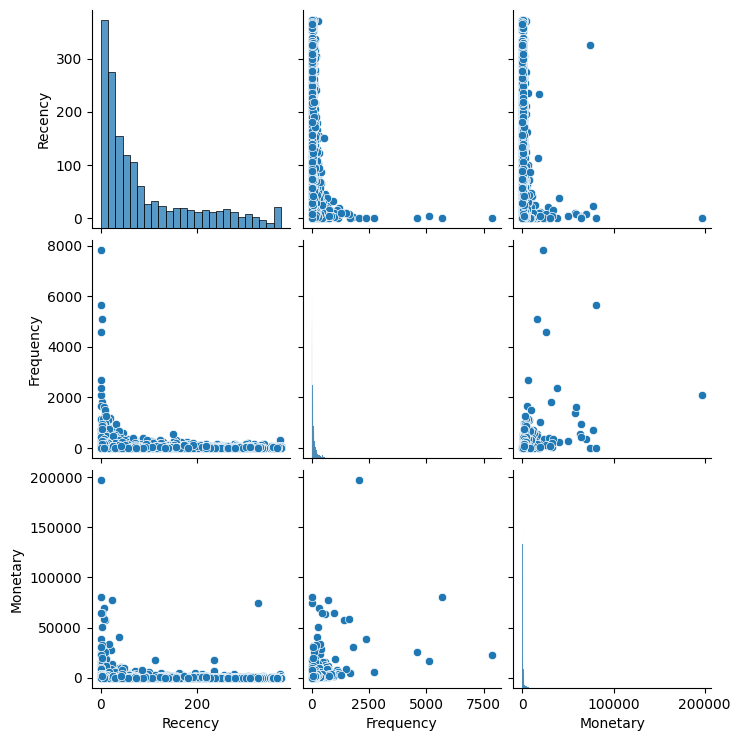

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# HISTOGRAM
sns.pairplot(rfm_df[['Recency', 'Frequency', 'Monetary']])
plt.show()

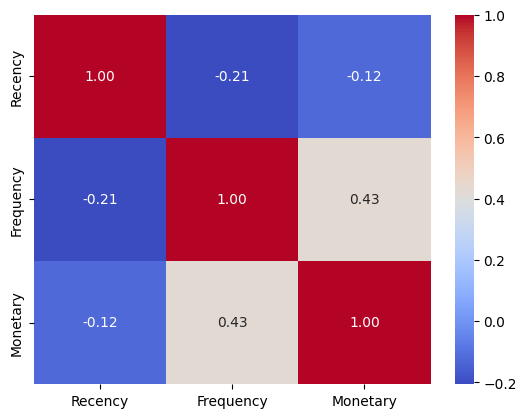

In [45]:
# CORRELATION
corr = rfm_df[['Recency', 'Frequency', 'Monetary']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])


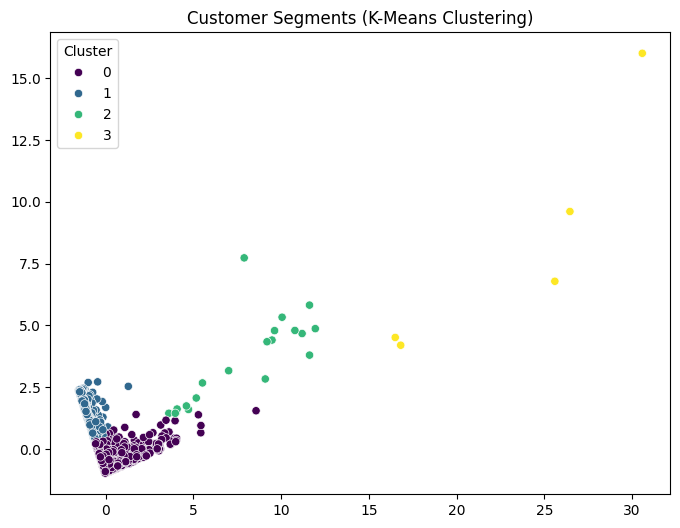

In [57]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)

# KMeans model
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

#
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=rfm_df['Cluster'], palette='viridis')
plt.title('Customer Segments (K-Means Clustering)')
plt.show()


In [58]:
from sklearn.metrics import silhouette_score

# SILHOUETTE SCORE
sil_score = silhouette_score(rfm_scaled, rfm_df['Cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.6067577083348213


In [59]:
# AVG Recency, Frequency, and Monetary for each cluster
rfm_df['Cluster'] = kmeans.labels_
cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_summary)


            Recency    Frequency      Monetary
Cluster                                       
0         40.536299   102.152919   1094.557924
1        246.427112    27.739090    286.761374
2         23.750000   603.450000  49329.650000
3          1.000000  5062.200000  68635.400000


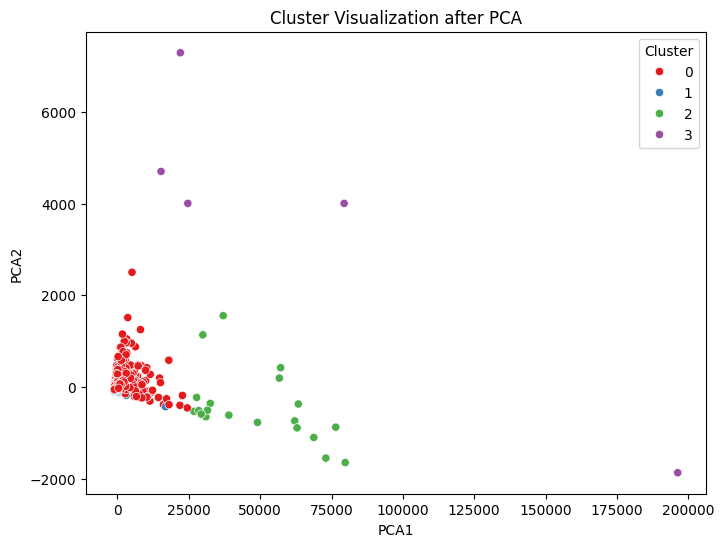

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

rfm_df['PCA1'], rfm_df['PCA2'] = pca_components[:, 0], pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1')
plt.title('Cluster Visualization after PCA')
plt.show()


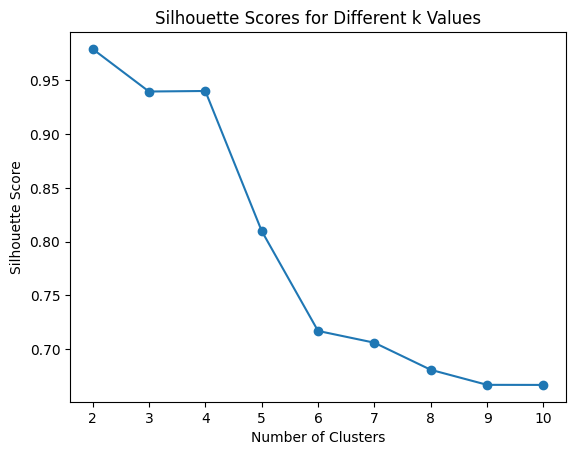

In [61]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_df[['Recency', 'Frequency', 'Monetary']])
    score = silhouette_score(rfm_df[['Recency', 'Frequency', 'Monetary']], kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k Values')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


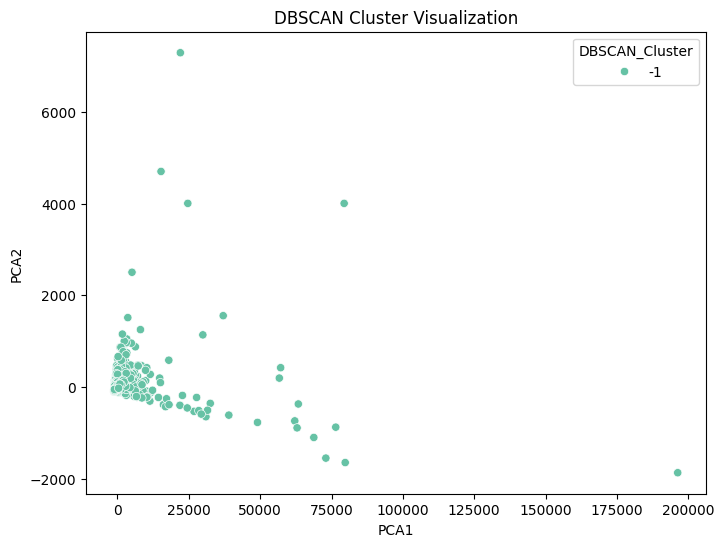

In [62]:
from sklearn.cluster import DBSCAN
# DBSCAN MODEL
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm_df['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='Set2')
plt.title('DBSCAN Cluster Visualization')
plt.show()


In [63]:
segment_profiles = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(segment_profiles)


   Cluster     Recency    Frequency      Monetary
0        0   40.536299   102.152919   1094.557924
1        1  246.427112    27.739090    286.761374
2        2   23.750000   603.450000  49329.650000
3        3    1.000000  5062.200000  68635.400000


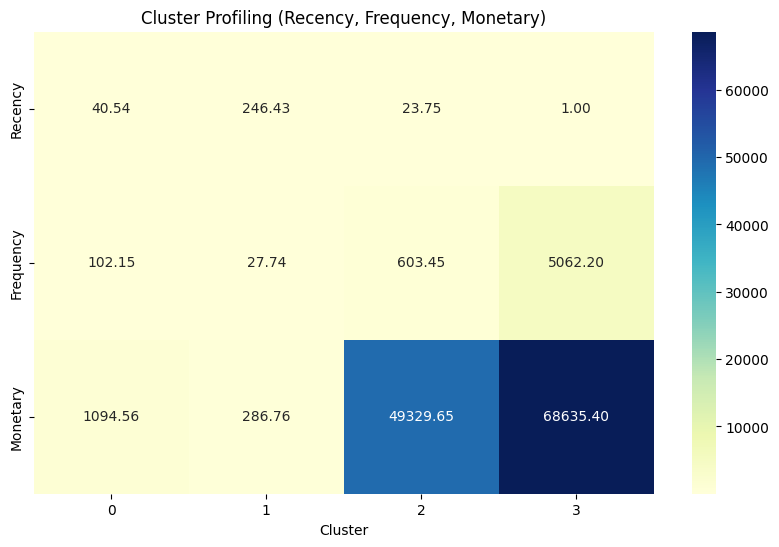

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

plt.figure(figsize=(10, 6))

#HEATMAP
sns.heatmap(cluster_summary.set_index('Cluster').T, annot=True, cmap='YlGnBu', fmt=".2f")

plt.title('Cluster Profiling (Recency, Frequency, Monetary)')
plt.show()


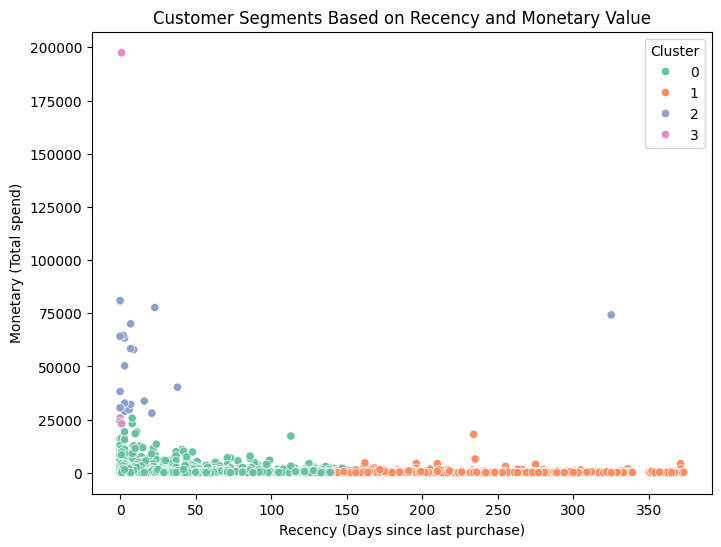

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2D SCATTER PLOT
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm_df, palette='Set2')
plt.title('Customer Segments Based on Recency and Monetary Value')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary (Total spend)')
plt.legend(title='Cluster')
plt.show()


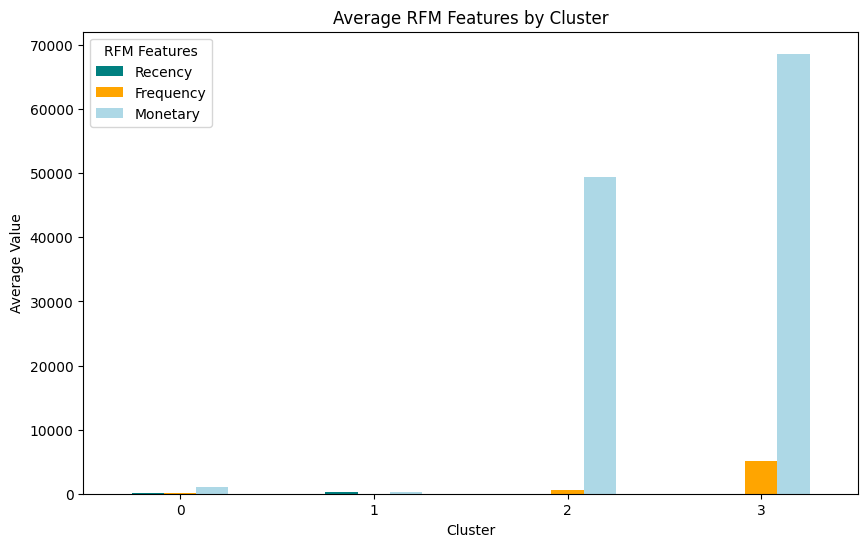

In [67]:
#BAR CHART
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

cluster_summary.set_index('Cluster').plot(kind='bar', figsize=(10, 6), color=['teal', 'orange', 'lightblue'])
plt.title('Average RFM Features by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='RFM Features')
plt.show()


In [68]:
rfm_df.to_csv('rfm_segmentation.csv', index=False)
